In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
from matplotlib import animation as animation

In [2]:
class Tree(object):
    def __init__(self, tree_type = "tree1", STATE = None):
        self.tree_type = tree_type
        self.STATE = STATE
        if tree_type == "tree1":
            self.BURN_TIME = 2
        elif tree_type == "tree2":
            self.BURN_TIME = 10
        else:
            self.BURN_TIME = 2
        self.BURN_TIMER = 0

class simulateStochasticFire():
    def __init__(self, N = 10,
                 INERT = 0 ,
                RECOVERING= 1 ,
                BURNT = 2 ,
                BURNING = 3 ,
                WATERED = 5,
                FIRE_SPREAD_PROB = .5,
                BURNOUT_PROB = .6,
                SELF_RECOVERY_PROB =.03,
                NEIGHBOR_RECOVERY_PROB = .1,
                COMPLETE_RECOVERY_PROB = .05,
                ):
        random.seed(0)

        self.N = N 

        self.INERT = INERT
        self.RECOVERING= RECOVERING
        self.BURNT = BURNT
        self.BURNING = BURNING
        self.WATERED = WATERED

        self.FIRE_SPREAD_PROB = FIRE_SPREAD_PROB
        self.BURNOUT_PROB = BURNOUT_PROB
        self.SELF_RECOVERY_PROB = SELF_RECOVERY_PROB
        self.NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB
        self.COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB

        self.burn_proportion = []
        self.burnt_proportion = []
        self.burnt_region = np.zeros((self.N, self.N))

        self.tree1_dist = 0.8
        self.tree2_dist = 1 - self.tree1_dist

        self.ntree = self.N*self.N
        self.ntree1 = int(self.tree1_dist*self.ntree)
        self.ntree2 = int(self.tree2_dist*self.ntree)

        self.ntree1_ON = int(0.009*self.ntree1)
        self.ntree2_ON = int(0.009*self.ntree2)

        self.cells = np.zeros((self.N, self.N), dtype = object)

        x_idxs, y_idxs = np.array(range(self.N)), np.array(range(self.N))
        x_idxs, y_idxs = np.meshgrid(x_idxs, y_idxs)
        x_idxs, y_idxs = x_idxs.ravel(), y_idxs.ravel()
        
        # TODO: Change initialization
        tree1_x_idxs, tree1_y_idxs = x_idxs[0:self.ntree1], y_idxs[0:self.ntree1]
        tree2_x_idxs, tree2_y_idxs = x_idxs[self.ntree1:], y_idxs[self.ntree1:]

        for x, y in zip(tree1_x_idxs, tree1_y_idxs):
            self.cells[x, y] = Tree(tree_type="tree1", STATE=self.INERT)
        for x, y in zip(tree2_x_idxs, tree2_y_idxs):
            self.cells[x, y] = Tree(tree_type="tree2", STATE=self.INERT)
        
        self.init_fire()
        
        # for x, y in zip(tree1_ON_x_idxs, tree1_ON_y_idxs):
        #     self.cells[x, y].STATE = self.BURNING
        # for x, y in zip(tree2_ON_x_idxs, tree2_ON_y_idxs):
        #     self.cells[x, y].STATE = self.BURNING

        self.adj_dict = {}
        for x in range(self.N):
            for y in range(self.N):
                self.adj_dict[(x,y)] = [(x - 1, y - 1), (x - 1, y), (x - 1, y + 1),
                                (x, y - 1), (x, y + 1),
                                (x + 1, y - 1), (x + 1, y), (x + 1, y + 1)]
        
        self.fig, self.ax = plt.subplots(figsize = (6,6))
        forest_grid = self.get_state_grid()
        self.img = self.ax.imshow(forest_grid.astype(int))

    def init_fire(self):
        # for x in range (1, self.N//3):
        #     self.cells[x,x].STATE = self.BURNING
        #     self.cells[2 * x,x//2].STATE = self.BURNING
        #     self.cells[3 * x,x//2].STATE = self.BURNING
        #--------
        # for x in range(1, self.N//10):
        #   for y in range(1, self.N//10):
        #     self.cells[x, y].STATE = self.BURNING
        #--------
        self.cells[int(self.N/2), int(self.N/2)].STATE = self.BURNING

    def run_one_step(self, data):
        newGrid = copy.deepcopy(self.cells)#.copy()
        for x in range(1, self.N - 1):
            for y in range(1, self.N - 1):
                curr_state = self.cells[x,y].STATE
                if np.sum(np.abs(curr_state - self.BURNING)) == 0: 
                    for neighbor in self.adj_dict[(x, y)]:
                        if np.sum(np.abs(newGrid[neighbor].STATE - self.INERT)) == 0 and random.random() < self.FIRE_SPREAD_PROB:
                            newGrid[neighbor].STATE = self.BURNING
                    if (newGrid[x, y].BURN_TIMER > newGrid[x, y].BURN_TIME) and (random.random() < self.BURNOUT_PROB):
                        newGrid[x, y].STATE = self.BURNT
                        newGrid[x, y].BURN_TIMER = 0
                    else:
                        newGrid[x, y].BURN_TIMER += 1
                elif np.sum(np.abs(curr_state - self.BURNT)) == 0 and random.random() < self.SELF_RECOVERY_PROB:
                    newGrid[x, y].STATE = self.RECOVERING
                elif np.sum(np.abs(curr_state - self.RECOVERING)) == 0:
                    for neighbor in self.adj_dict[(x, y)]:
                        if np.sum(np.abs(newGrid[neighbor].STATE - self.BURNT)) == 0 and (random.random() < self.NEIGHBOR_RECOVERY_PROB):
                            newGrid[neighbor].STATE = self.RECOVERING
                    if random.random() < self.COMPLETE_RECOVERY_PROB:
                        newGrid[x, y].STATE = self.INERT
                elif np.sum(np.abs(curr_state - self.WATERED)) == 0:
                    newGrid[x, y].STATE = self.RECOVERING
        
        currently_burning = []
        watering = []
        for x in range(N):
            for y in range(N):
                if np.sum(np.abs(newGrid[x, y].STATE - self.BURNING)) == 0:
                    currently_burning.append((x,y))
                    self.burnt_region[x,y] = 1
        
        if currently_burning:
            watering = np.random.choice(range(len(currently_burning)), size = int(0.1*len(currently_burning)), replace = False)
        
        for w in watering:
            newGrid[currently_burning[w]].STATE = self.WATERED
      
        self.burn_proportion.append(len(currently_burning)/(self.N*self.N))
        self.burnt_proportion.append(np.sum(self.burnt_region)/(self.N*self.N))

        forest_grid = self.get_state_grid()
        self.img.set_array(forest_grid.astype(int))

        self.cells = newGrid

        return [self.img]
        
    
    def run(self, T):
        pseudo_argument = T
        for t in range(T):
            self.run_one_step(pseudo_argument)
    
    def get_state_grid(self):
        grid = np.zeros((self.N, self.N, 3), dtype=int)
        for x in range(grid.shape[0]):
            for y in range(grid.shape[1]):
                grid[x,y,:] = self.cells[x,y].STATE
        return grid

    def plot_forest(self):
        grid = np.zeros((self.N, self.N, 3), dtype=int)
        for x in range(grid.shape[0]):
            for y in range(grid.shape[1]):

                grid[x,y,:] = self.cells[x,y].STATE
        plt.imshow(grid)
        plt.show()
    
    def animate_forest(self, T=20):
        ani = animation.FuncAnimation(self.fig, self.run_one_step, interval=T,save_count=T)
        return ani

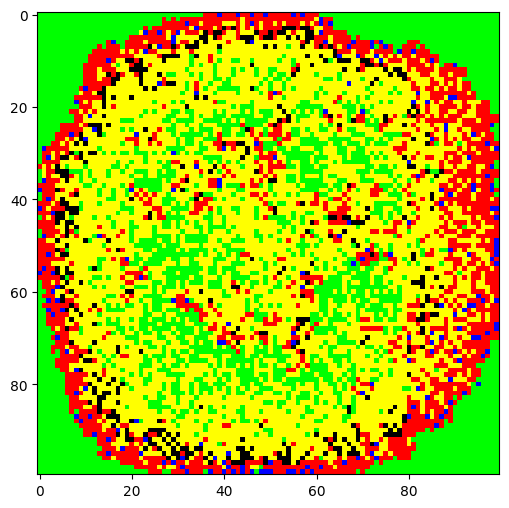

In [3]:
N = 100

INERT = (0, 255, 0) # Green can be ignited
BURNING = (255, 0, 0) #Red # BURNING is burning 
BURNT = (0, 0, 0) #Black # burnt is not actively recovering
RECOVERING= (255, 255, 0) # Yellow # is recovering 
WATERED = (0, 0, 255) # Blue watering the cell

BURNING = np.array(BURNING, dtype=int)
BURNT = np.array(BURNT, dtype = int)
RECOVERING = np.array(RECOVERING, dtype = int)
INERT = np.array(INERT, dtype = int)
WATERED = np.array(WATERED, dtype = int)

FIRE_SPREAD_PROB = 0.5
BURNOUT_PROB = 0.6
SELF_RECOVERY_PROB = 0.03
NEIGHBOR_RECOVERY_PROB = 0.1
COMPLETE_RECOVERY_PROB = 0.05

sim = simulateStochasticFire(
        N = N ,
        INERT = INERT,
        RECOVERING= RECOVERING,
        BURNT = BURNT,
        BURNING = BURNING,
        WATERED = WATERED,
        FIRE_SPREAD_PROB = FIRE_SPREAD_PROB,
        BURNOUT_PROB = BURNOUT_PROB,
        SELF_RECOVERY_PROB = SELF_RECOVERY_PROB,
        NEIGHBOR_RECOVERY_PROB = NEIGHBOR_RECOVERY_PROB,
        COMPLETE_RECOVERY_PROB = COMPLETE_RECOVERY_PROB,
        )

ani = sim.animate_forest(T=50)
from IPython.display import HTML
HTML(ani.to_jshtml())